In [1]:
import os
import torch
from torch import nn 
import pandas as pd
import torchvision
import tarfile
import torch

In [2]:
data_dir = 'hs5/'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['Test', 'Train']
['celtic', 'isis', 'sonnenrand', 'ss', 'swastika']


In [3]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [4]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [5]:
print(dataset.classes)

['celtic', 'isis', 'sonnenrand', 'ss', 'swastika']


In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [7]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0)) # transforms 3, 32, 32 to 32, 32, 3 to be displayed in matplotlib

Label:  ss (3)


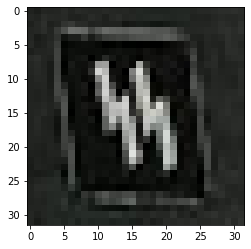

In [8]:
show_example(*dataset[369])

In [9]:
random_seed = 42
torch.manual_seed(random_seed);

In [10]:

val_size = 60
train_size = len(dataset) - val_size

train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(540, 60)

In [11]:
from torch.utils.data.dataloader import DataLoader

batch_size=60

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [13]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


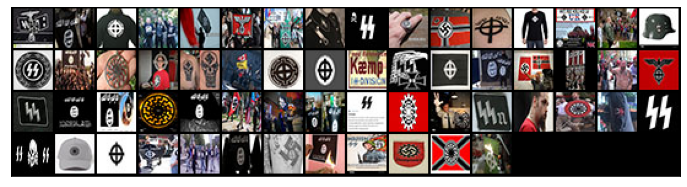

In [14]:
show_batch(train_dl)

In [15]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [16]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [19]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([60, 3, 32, 32])
out.shape: torch.Size([60, 8, 16, 16])


In [20]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
class Hs5CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [22]:
model = Hs5CnnModel()
model

Hs5CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [23]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([60, 3, 32, 32])
out.shape: torch.Size([60, 10])
out[0]: tensor([ 0.0320,  0.0351, -0.0045,  0.0309,  0.0357, -0.0290,  0.0277,  0.0287,
         0.0146, -0.0443], grad_fn=<SelectBackward0>)


In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [27]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
model = to_device(Hs5CnnModel(), device)

In [29]:
evaluate(model, val_dl)

{'val_loss': 2.303236484527588, 'val_acc': 0.20000000298023224}

In [30]:
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.001

In [31]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 1.9347, val_loss: 1.7910, val_acc: 0.2333
Epoch [1], train_loss: 1.6975, val_loss: 1.6291, val_acc: 0.2167
Epoch [2], train_loss: 1.6310, val_loss: 1.6337, val_acc: 0.2000
Epoch [3], train_loss: 1.6318, val_loss: 1.6203, val_acc: 0.2333
Epoch [4], train_loss: 1.6173, val_loss: 1.6120, val_acc: 0.2167
Epoch [5], train_loss: 1.6212, val_loss: 1.6119, val_acc: 0.1500
Epoch [6], train_loss: 1.6336, val_loss: 1.6258, val_acc: 0.2000
Epoch [7], train_loss: 1.6265, val_loss: 1.6283, val_acc: 0.2000
Epoch [8], train_loss: 1.6360, val_loss: 1.6252, val_acc: 0.2333
Epoch [9], train_loss: 1.6281, val_loss: 1.6388, val_acc: 0.1500
Epoch [10], train_loss: 1.6259, val_loss: 1.6135, val_acc: 0.2000
Epoch [11], train_loss: 1.6198, val_loss: 1.6214, val_acc: 0.1500
Epoch [12], train_loss: 1.6167, val_loss: 1.6186, val_acc: 0.2000
Epoch [13], train_loss: 1.6252, val_loss: 1.6156, val_acc: 0.1500
Epoch [14], train_loss: 1.6170, val_loss: 1.6165, val_acc: 0.2333
Epoch [15], train_lo

In [32]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

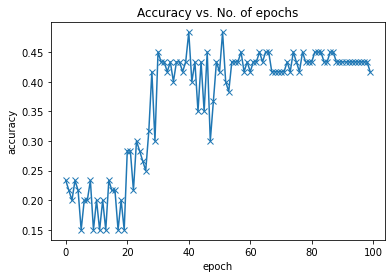

In [33]:
plot_accuracies(history)

In [34]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

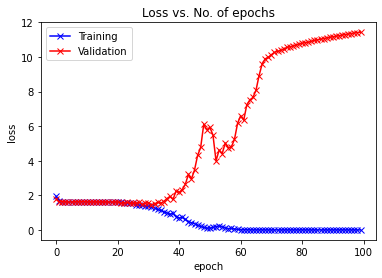

In [35]:
plot_losses(history)

## test

In [36]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [37]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: celtic , Predicted: celtic


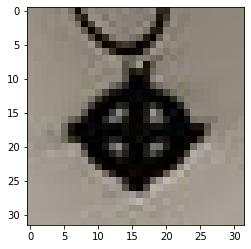

In [38]:
img, label = test_dataset[5]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [39]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.8487598299980164, 'val_acc': 0.9555554986000061}

## SAVE

In [48]:
state = { 'state_dict': model.state_dict() } 

In [49]:
torch.save(state, 'hs5-cnn.pth')

In [50]:
model2 = to_device(Hs5CnnModel(), device)

In [52]:
model2.load_state_dict(torch.load('hs5-cnn.pth')['state_dict'])

<All keys matched successfully>

In [53]:
evaluate(model2, test_loader)

{'val_loss': 0.8487598299980164, 'val_acc': 0.9555554986000061}